In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# UNET

In [ ]:
from abc import ABC
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.io import imread
from skimage.transform import resize
from time import time

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Функция отображает первые 6 изображений и соответствующие маски.
def plot_images():
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(X[i])
        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.imshow(Y[i])
    plt.show()
# Загрузка и обработка изображений и масок (изменяет размер до 256x256)
images = []
lesions = []
root = '/content/drive/MyDrive/Colab Notebooks/PH2Dataset'
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
  if root.endswith('_Dermoscopic_Image'):
    images.append(imread(os.path.join(root, files[0])))
  if root.endswith('_lesion'):
    lesions.append(imread(os.path.join(root, files[0])))
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')
len(lesions)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150]) # Делит индексы на три части: тренировочный (100 изображений), валидационный (50 изображений) и тестовый (50 изображений)
print(len(tr), len(val), len(ts)) # Выводит количество изображений в каждом из наборов

Loaded 200 images
100 50 50


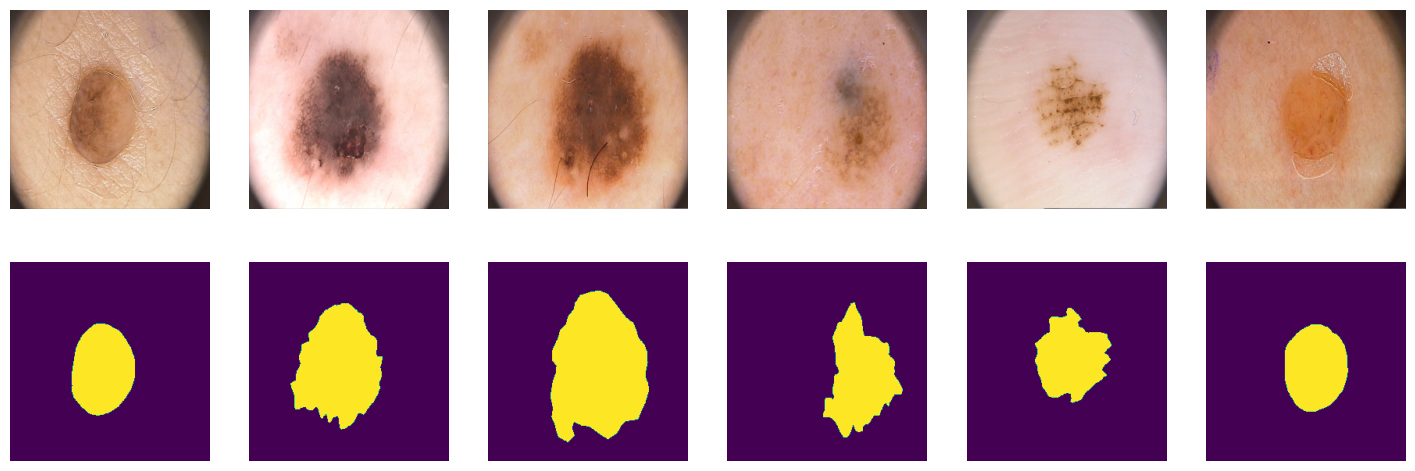

In [ ]:
plot_images()

In [ ]:
batch_size = 12
# Подготавливаем данные для обучения, преобразуя их в формат, совместимый с PyTorch
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), batch_size=batch_size, shuffle=True)

In [ ]:
def double_conv(in_channels, out_channels):
 return nn.Sequential(
 nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
 nn.ReLU(inplace=True),
 nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
 nn.ReLU(inplace=True))
def crop_image(input_tensor, target_tensor):
 target_size = target_tensor.size()[2]
 tensor_size = input_tensor.size()[2]
 delta = (tensor_size - target_size) // 2
 return input_tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

class UNet(nn.Module, ABC):
  def __init__(self):
    super().__init__()
    self.conv_down1 = double_conv(3, 64)
    self.conv_down2 = double_conv(64, 128)
    self.conv_down3 = double_conv(128, 256)
    self.conv_down4 = double_conv(256, 512)
    self.conv_down5 = double_conv(512, 1024)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.trans_up1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
    self.conv_up1 = double_conv(1024, 512)
    self.trans_up2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
    self.conv_up2 = double_conv(512, 256)
    self.trans_up3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.conv_up3 = double_conv(256, 128)
    self.trans_up4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.conv_up4 = double_conv(128, 64)
    self.last_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, image):
    # Encoder part
    x1 = self.conv_down1(image)
    x2 = self.maxpool(x1)
    x3 = self.conv_down2(x2)
    x4 = self.maxpool(x3)
    x5 = self.conv_down3(x4)
    x6 = self.maxpool(x5)
    x7 = self.conv_down4(x6)
    x8 = self.maxpool(x7)
    x9 = self.conv_down5(x8)
    # Decoder part
    x = self.trans_up1(x9)
    y = crop_image(x7, x)
    x = self.conv_up1(torch.cat([x, y], 1))
    x = self.trans_up2(x)
    y = crop_image(x5, x)
    x = self.conv_up2(torch.cat([x, y], 1))
    x = self.trans_up3(x)
    y = crop_image(x3, x)
    x = self.conv_up3(torch.cat([x, y], 1))
    x = self.trans_up4(x)
    y = crop_image(x1, x)
    x = self.conv_up4(torch.cat([x, y], 1))
    out = self.last_conv(x)
    return out

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels:torch.Tensor):
  outputs = outputs.squeeze(1).byte()
  labels = labels.squeeze(1).byte()
  smooth = 1e-8
  intersection = (outputs & labels).float().sum((1, 2))
  union = (outputs | labels).float().sum((1, 2))
  iou = (intersection + smooth) / (union + smooth)
  thresholded = torch.clamp(20 * (iou - 0.5), 0,10).ceil() / 10
  return thresholded

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    x_val, y_val = next(iter(data_val))
    start_time = time()
    for epoch in range(epochs):
        avg_loss = 0
        model.train() # train mode
        for X_batch, Y_batch in data_tr:
            inputs = X_batch.to(device)
            labels = Y_batch.to(device)
            opt.zero_grad()
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)

        model.eval()
        avg_loss2 = 0  # Initialize avg_loss2 here
        for X_batch2, Y_batch2 in data_val:
            inputs2 = X_batch2.to(device)
            y_pred2 = model(inputs2).cpu().detach()
            loss2 = loss_fn(y_pred2, Y_batch2)
            avg_loss2 += loss2 / len(data_val)

        train_score = score_model(model, iou_pytorch, data_tr)
        test_score = score_model(model, iou_pytorch, data_val)

        if (epoch+1) % 1 == 0:
            print('Epoch: %d/%d, train loss: %f, test loss: %f, train score: %f, test score: %f' % (epoch+1, epochs, avg_loss, avg_loss2, train_score, test_score))

        if epoch+1 == epochs:
            y_hat = model(x_val.to(device)).detach().to('cpu')
            show_images(x_val, y_val, y_hat, epoch+1, epochs, avg_loss)

    print('Elapsed time: %s' % np.round((time() - start_time), 1))

In [ ]:
def predict(model1, data):
  model1.eval()
  y_pred = [X_batch for X_batch, _ in data]
  return np.array(y_pred)

def score_model(model1, metric, data):
  model1.eval()
  scores = 0
  threshold = 0.5
  for X_batch, Y_label in data:
    y_pred = model(X_batch.to(device))
    y_pred = (y_pred > threshold).float()
    scores += metric(y_pred, Y_label.to(device)).mean().item()
  return scores/len(data)

def show_images(x_val, y_val, y_hat, epoch, epochs, avg_loss):
  for k in range(6):
    plt.subplot(3, 6, k + 1)
    plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.subplot(3, 6, k + 7)
    plt.imshow(y_val[k, 0], cmap='gray')
    plt.title('Labels')
    plt.axis('off')
    plt.subplot(3, 6, k + 13)
    plt.imshow(np.round(y_hat[k, 0].numpy()),cmap='gray')
    plt.title('Predicted')
    plt.axis('off')
  plt.suptitle('%d / %d - loss: %f' % (epoch, epochs, avg_loss))
  plt.show()

Epoch: 1/70, train loss: 0.695871, test loss: 0.694703, train score: 0.000000, test score: 0.000000
Epoch: 2/70, train loss: 0.693334, test loss: 0.692183, train score: 0.000000, test score: 0.000000
Epoch: 3/70, train loss: 0.691355, test loss: 0.690093, train score: 0.000000, test score: 0.000000
Epoch: 4/70, train loss: 0.689678, test loss: 0.690426, train score: 0.000000, test score: 0.000000
Epoch: 5/70, train loss: 0.688171, test loss: 0.688129, train score: 0.000000, test score: 0.000000
Epoch: 6/70, train loss: 0.687526, test loss: 0.686777, train score: 0.000000, test score: 0.000000
Epoch: 7/70, train loss: 0.685810, test loss: 0.686339, train score: 0.000000, test score: 0.000000
Epoch: 8/70, train loss: 0.684457, test loss: 0.685190, train score: 0.000000, test score: 0.000000
Epoch: 9/70, train loss: 0.682982, test loss: 0.682431, train score: 0.000000, test score: 0.000000
Epoch: 10/70, train loss: 0.680962, test loss: 0.679935, train score: 0.000000, test score: 0.000000

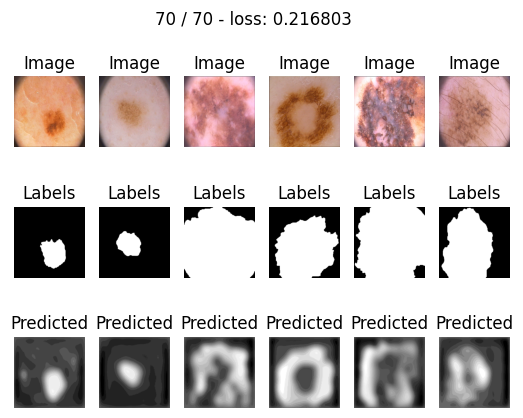

Elapsed time: 641.5


In [ ]:
max_epochs = 70
model = UNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
train(model, optim, loss_function, max_epochs, data_tr, data_val)
final_score = score_model(model, iou_pytorch, data_ts)

# SEGNET

In [ ]:
from abc import ABC
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.io import imread
from skimage.transform import resize
from time import time
from google.colab import drive

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def plot_images():
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(X[i])
        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.imshow(Y[i])
    plt.show()

images = []
lesions = []
root = '/content/drive/MyDrive/Colab Notebooks/PH2Dataset'
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')
len(lesions)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])
print(len(tr), len(val), len(ts))
batch_size = 12

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), batch_size=batch_size, shuffle=True)

Loaded 200 images
100 50 50


Epoch: 1/50, train loss: 0.714301, test loss: 0.693544, train score: 0.000000, test score: 0.000000
Epoch: 2/50, train loss: 0.705457, test loss: 0.694186, train score: 0.000000, test score: 0.000000
Epoch: 3/50, train loss: 0.695851, test loss: 0.690518, train score: 0.000000, test score: 0.000000
Epoch: 4/50, train loss: 0.676129, test loss: 0.679917, train score: 0.000000, test score: 0.000000
Epoch: 5/50, train loss: 0.637925, test loss: 0.633010, train score: 0.000000, test score: 0.000000
Epoch: 6/50, train loss: 0.593359, test loss: 0.568648, train score: 0.102778, test score: 0.106667
Epoch: 7/50, train loss: 0.554078, test loss: 0.519127, train score: 0.251852, test score: 0.203333
Epoch: 8/50, train loss: 0.528336, test loss: 0.491484, train score: 0.378704, test score: 0.341667
Epoch: 9/50, train loss: 0.504439, test loss: 0.459697, train score: 0.537037, test score: 0.508333
Epoch: 10/50, train loss: 0.478916, test loss: 0.432694, train score: 0.581482, test score: 0.500000

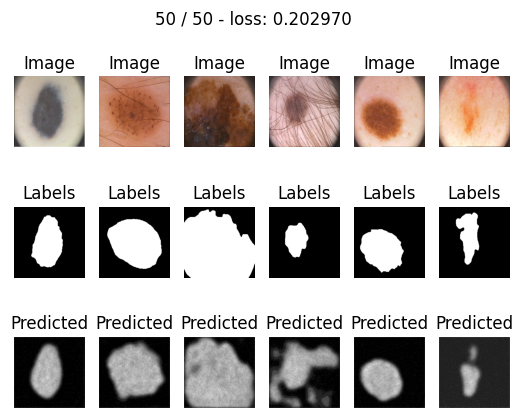

Elapsed time: 363.6


In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            )
    def forward(self, x):
        # encoder
        e0, indices_e0 = self.pool0(self.enc_conv0(x))
        e1, indices_e1 = self.pool1(self.enc_conv1(e0))
        e2, indices_e2 = self.pool2(self.enc_conv2(e1))
        e3, indices_e3 = self.pool3(self.enc_conv3(e2))
        # bottleneck
        b = self.bottleneck_conv(e3)
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, indices_e3))
        d1 = self.dec_conv1(self.upsample1(d0, indices_e2))
        d2 = self.dec_conv2(self.upsample2(d1, indices_e1))
        d3 = self.dec_conv3(self.upsample3(d2, indices_e0))  # no activation
        return d3

def iou_pytorch(outputs: torch.Tensor, labels:torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    smooth = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    thresholded = torch.clamp(20 * (iou - 0.5), 0,10).ceil() / 10
    return thresholded

def predict(model1, data):
    model1.eval()
    y_pred = [X_batch for X_batch, _ in data]
    return np.array(y_pred)

def score_model(model1, metric, data):
    model1.eval()
    scores = 0
    threshold = 0.5
    for X_batch, Y_label in data:
        y_pred = model(X_batch.to(device))
        y_pred = (y_pred > threshold).float()
        scores += metric(y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

def show_images(x_val, y_val, y_hat, epoch, epochs, avg_loss):
    for k in range(6):
        plt.subplot(3, 6, k + 1)
        plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3), cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(3, 6, k + 7)
        plt.imshow(y_val[k, 0], cmap='gray')
        plt.title('Labels')
        plt.axis('off')
        plt.subplot(3, 6, k + 13)
        plt.imshow(np.round(y_hat[k, 0].numpy()),cmap='gray')
        plt.title('Predicted')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch, epochs, avg_loss))
    plt.show()

def train(model, opt, loss_fn, epochs, data_tr, data_val):
    x_val, y_val = next(iter(data_val))
    start_time = time()
    for epoch in range(epochs):
        avg_loss = 0
        model.train() # train mode
        for X_batch, Y_batch in data_tr:
            inputs = X_batch.to(device)
            labels = Y_batch.to(device)
            opt.zero_grad()
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)

        model.eval()
        avg_loss2 = 0  # Initialize avg_loss2 here
        for X_batch2, Y_batch2 in data_val:
            inputs2 = X_batch2.to(device)
            y_pred2 = model(inputs2).cpu().detach()
            loss2 = loss_fn(y_pred2, Y_batch2)
            avg_loss2 += loss2 / len(data_val)

        train_score = score_model(model, iou_pytorch, data_tr)
        test_score = score_model(model, iou_pytorch, data_val)

        if (epoch+1) % 1 == 0:
            print('Epoch: %d/%d, train loss: %f, test loss: %f, train score: %f, test score: %f' % (epoch+1, epochs, avg_loss, avg_loss2, train_score, test_score))

        if epoch+1 == epochs:
            y_hat = model(x_val.to(device)).detach().to('cpu')
            show_images(x_val, y_val, y_hat, epoch+1, epochs, avg_loss)

    print('Elapsed time: %s' % np.round((time() - start_time), 1))

max_epochs = 50
model = SegNet()
model.to(device)
loss_function = nn.BCEWithLogitsLoss()
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
train(model, optim, loss_function, max_epochs, data_tr, data_val)
final_score = score_model(model, iou_pytorch, data_ts)